In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


# Loan Default Prediction | XGBoost Feature Importance & Insights

This notebook builds an end-to-end pipeline for predicting loan repayment using machine learning.  
It includes:
- 🔍 Exploratory Data Analysis (EDA)  
- ⚙️ Feature Engineering  
- 🌲 Model Training (Logistic Regression, Random Forest, XGBoost)  
- 📊 Feature Importance & Performance Comparison  

**Goal:** Identify key financial and demographic factors influencing loan repayment behavior.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay


In [3]:
train_path = '/kaggle/input/playground-series-s5e11/train.csv'
test_path = '/kaggle/input/playground-series-s5e11/test.csv'
sample_submission_path = '/kaggle/input/playground-series-s5e11/sample_submission.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(sample_submission_path)



# Data OverView

In [4]:
print("Train data shape:", train.shape)
print(train.head())
print(train.info())
print(train.isnull().sum())

Train data shape: (593994, 13)
   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  gender marital_status education_level employment_status  \
0          13.67  Female         Single     High School     Self-employed   
1          12.92    Male        Married        Master's          Employed   
2           9.76    Male         Single     High School          Employed   
3          16.10  Female         Single     High School          Employed   
4          10.21    Male        Married     High School          Employed   

         loan_purpose grade_subgrade  loan_paid_back  
0           

In [5]:
print("Test data shape:", test.shape)
print(test.head())
print(test.info())
print(test.isnull().sum())

Test data shape: (254569, 12)
       id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0  593994       28781.05                 0.049           626     11461.42   
1  593995       46626.39                 0.093           732     15492.25   
2  593996       54954.89                 0.367           611      3796.41   
3  593997       25644.63                 0.110           671      6574.30   
4  593998       25169.64                 0.081           688     17696.89   

   interest_rate  gender marital_status education_level employment_status  \
0          14.73  Female         Single     High School          Employed   
1          12.85  Female        Married        Master's          Employed   
2          13.29    Male         Single      Bachelor's          Employed   
3           9.57  Female         Single      Bachelor's          Employed   
4          12.80  Female        Married             PhD          Employed   

         loan_purpose grade_subgrade  
0    

# EDA

In [6]:
print(train.describe())

                  id  annual_income  debt_to_income_ratio   credit_score  \
count  593994.000000  593994.000000         593994.000000  593994.000000   
mean   296996.500000   48212.202976              0.120696     680.916009   
std    171471.442235   26711.942078              0.068573      55.424956   
min         0.000000    6002.430000              0.011000     395.000000   
25%    148498.250000   27934.400000              0.072000     646.000000   
50%    296996.500000   46557.680000              0.096000     682.000000   
75%    445494.750000   60981.320000              0.156000     719.000000   
max    593993.000000  393381.740000              0.627000     849.000000   

         loan_amount  interest_rate  loan_paid_back  
count  593994.000000  593994.000000   593994.000000  
mean    15020.297629      12.356345        0.798820  
std      6926.530568       2.008959        0.400883  
min       500.090000       3.200000        0.000000  
25%     10279.620000      10.990000        1.

Text(0.5, 1.0, 'Loan Payback Distribution')

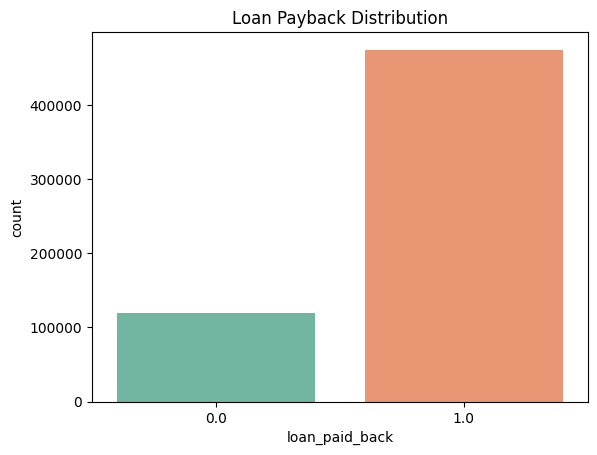

In [7]:
train['loan_paid_back'].value_counts(normalize=True) * 100
sns.countplot(data=train, x='loan_paid_back', palette='Set2')
plt.title('Loan Payback Distribution')

In [8]:
train['loan_paid_back'].value_counts()

loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64

## Univariate Analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


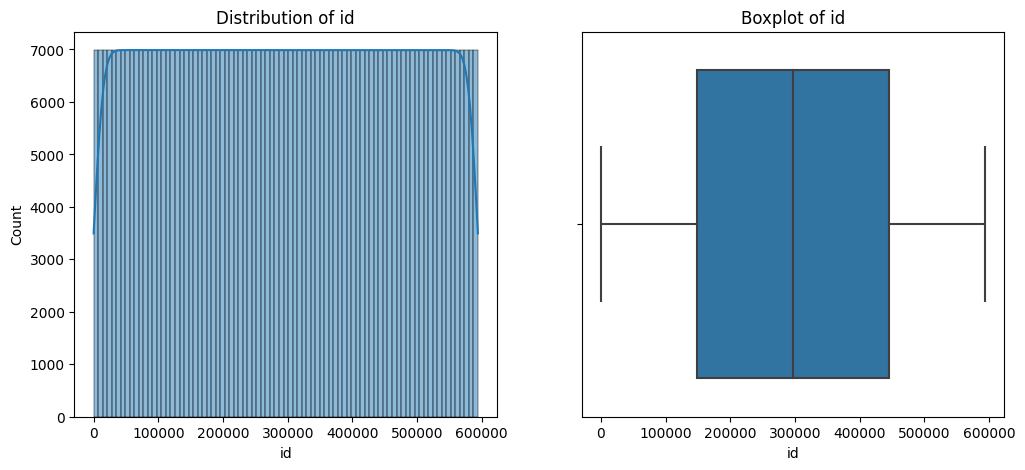

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


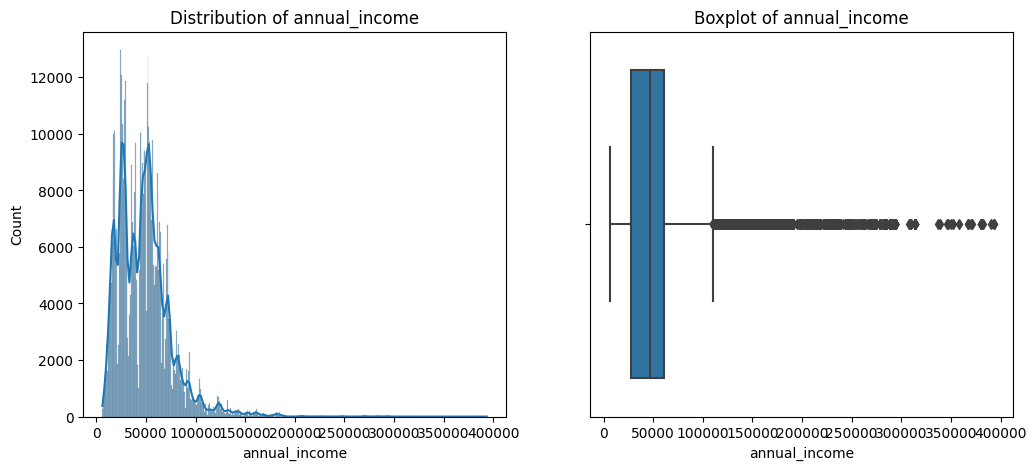

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


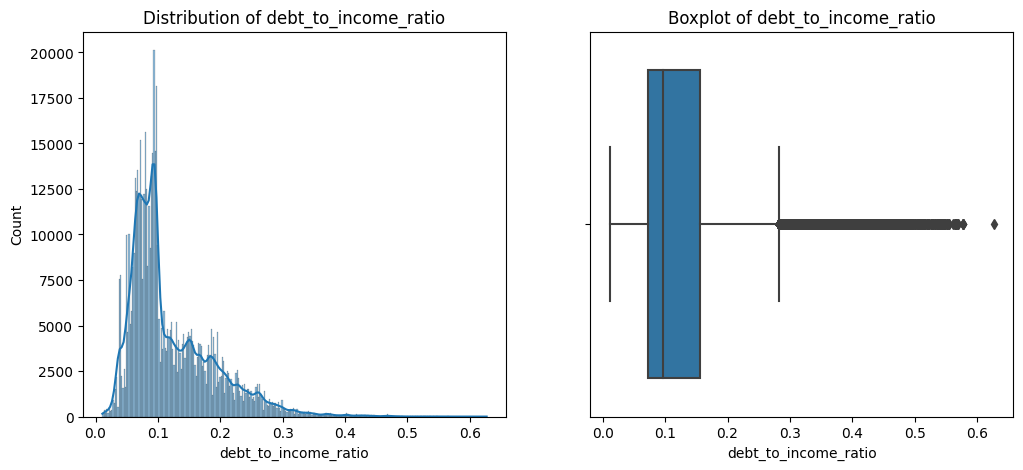

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


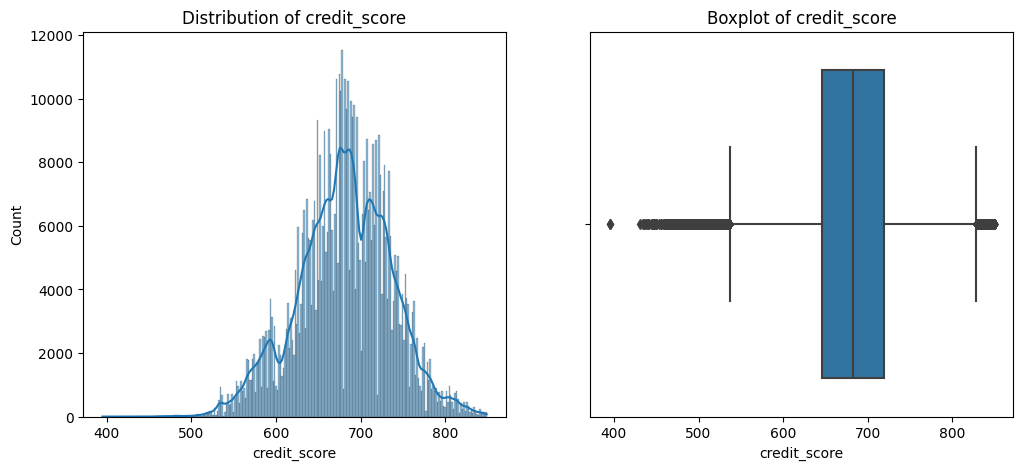

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


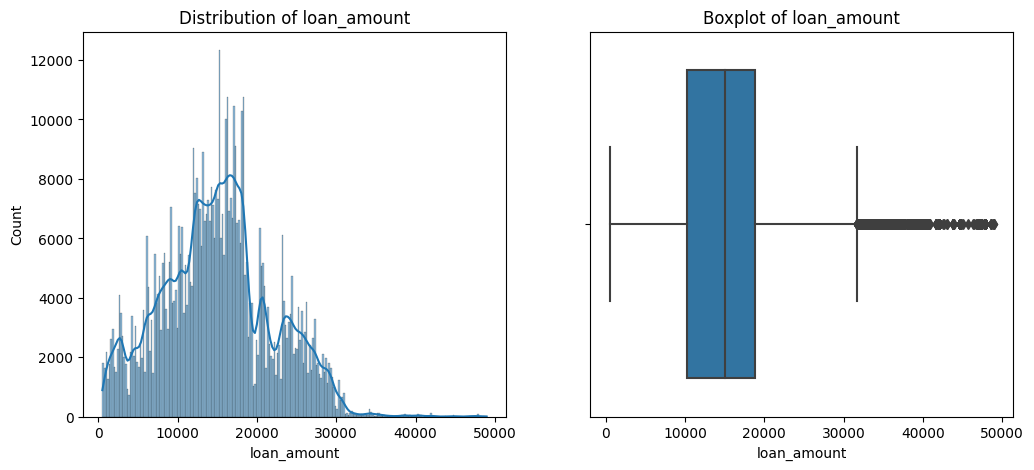

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


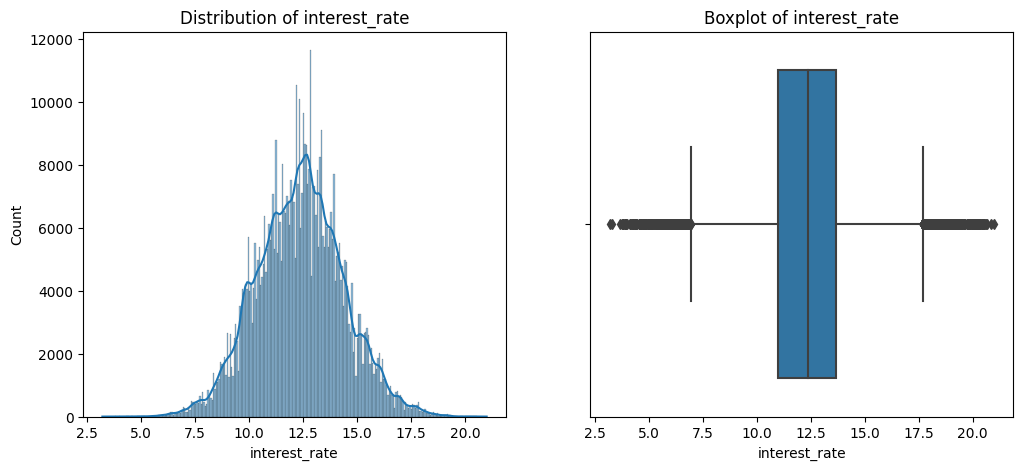

In [9]:
numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns.drop('loan_paid_back')
for col in numerical_cols:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(train[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.subplot(1,2,2)
    sns.boxplot(x=train[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

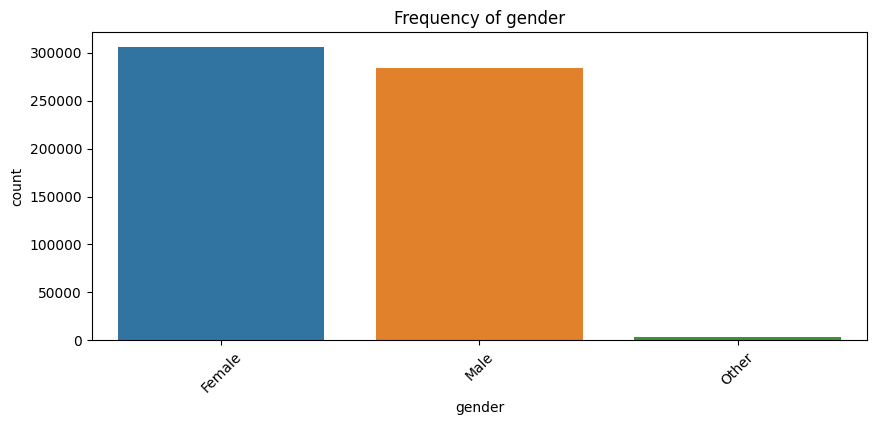

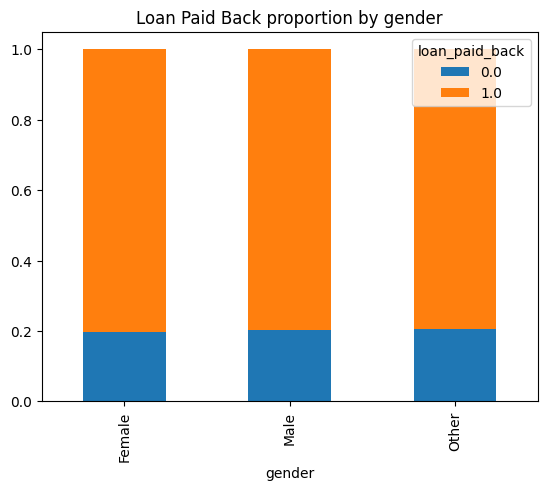

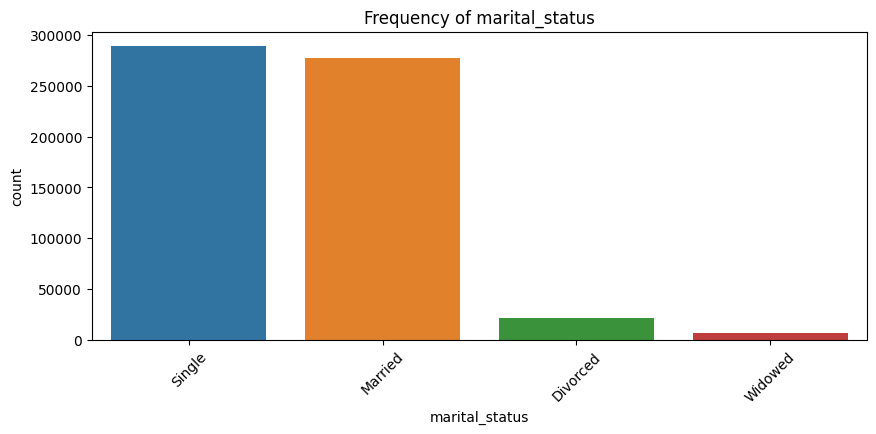

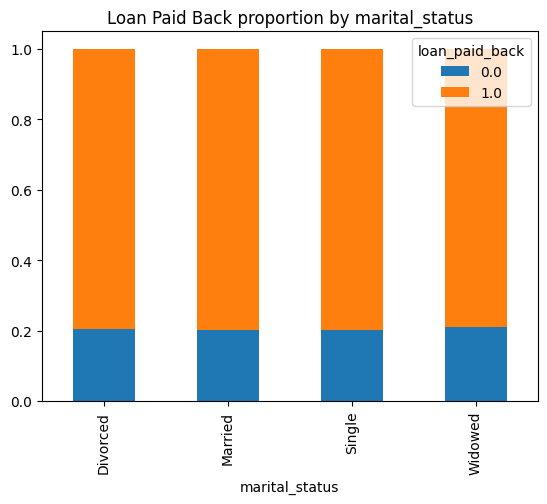

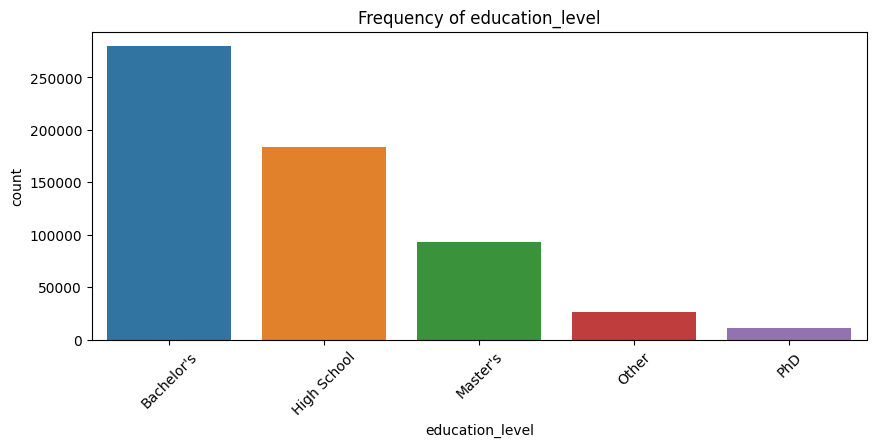

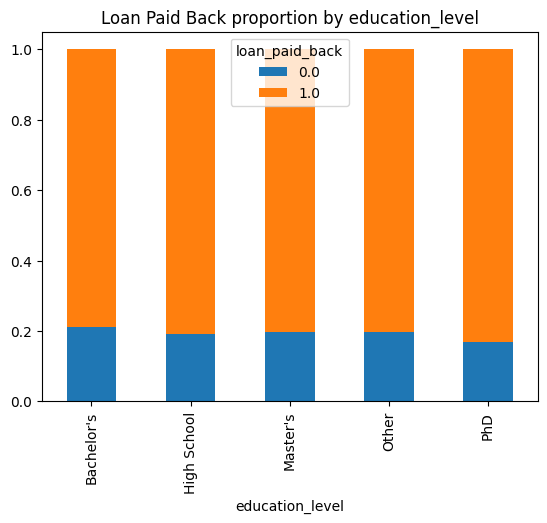

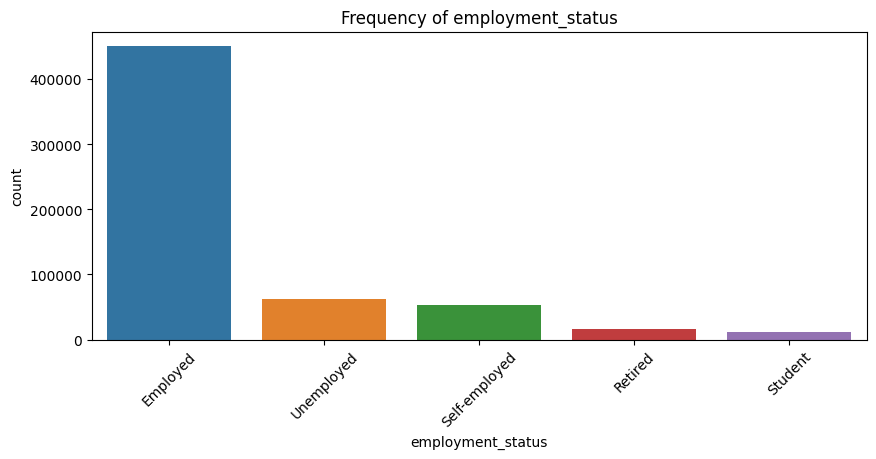

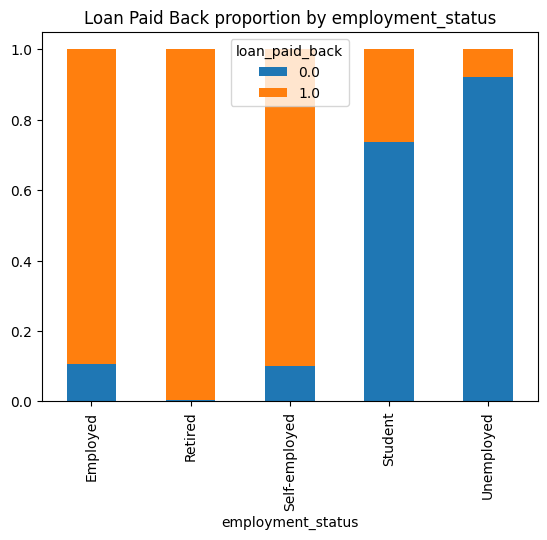

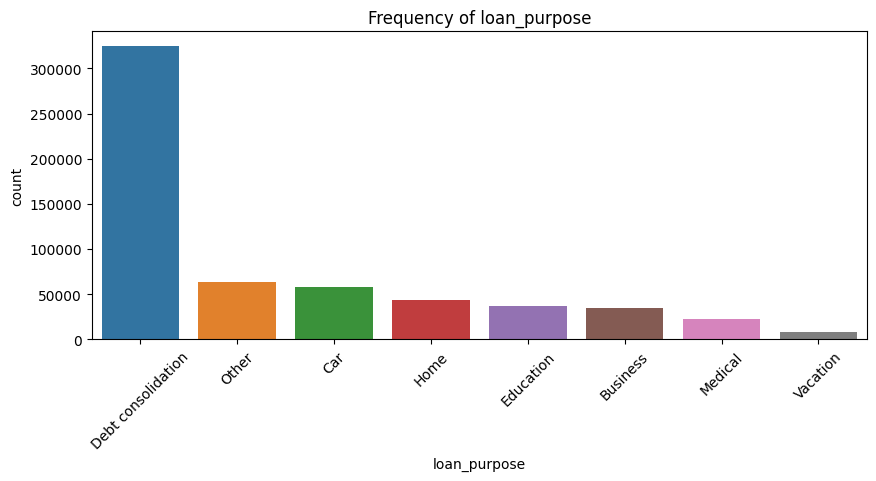

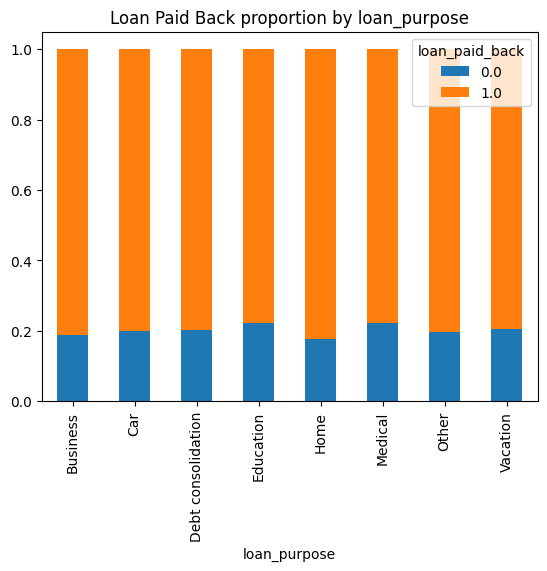

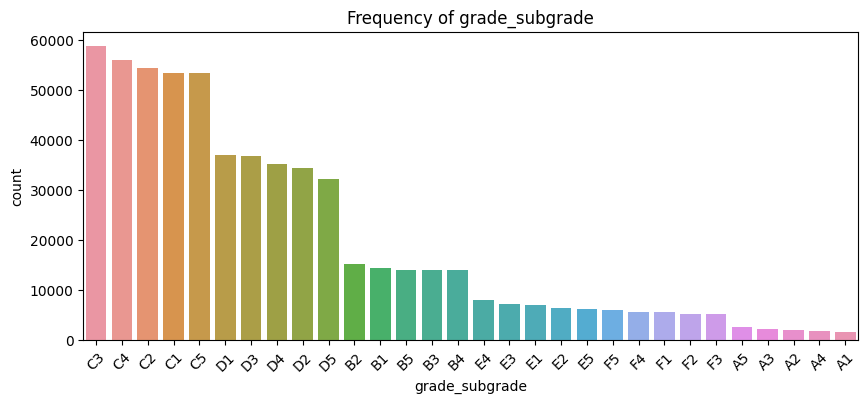

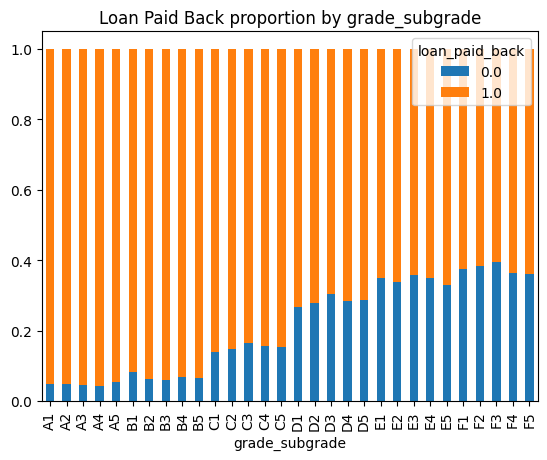

In [10]:
categorical_cols = train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(x=col, data=train, order=train[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Frequency of {col}')
    plt.show()
    
    # Target proportion by category (stacked bar)
    ct = pd.crosstab(train[col], train['loan_paid_back'], normalize='index')
    ct.plot(kind='bar', stacked=True)
    plt.title(f'Loan Paid Back proportion by {col}')
    plt.show()

## Bivariate Analysis

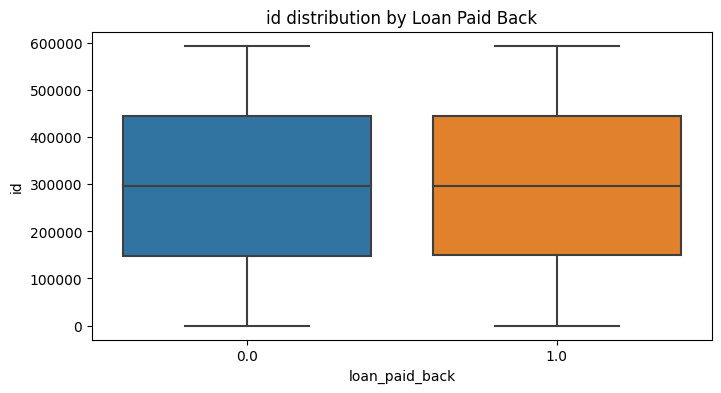

Mean of id by loan_paid_back:
loan_paid_back
0.0    296522.438678
1.0    297115.891031
Name: id, dtype: float64



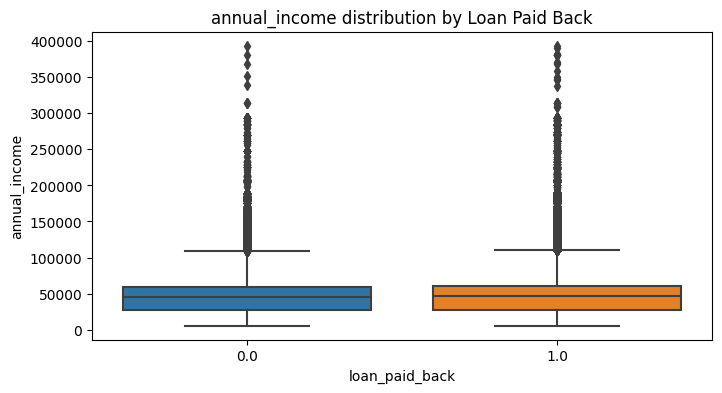

Mean of annual_income by loan_paid_back:
loan_paid_back
0.0    47875.503881
1.0    48296.999711
Name: annual_income, dtype: float64



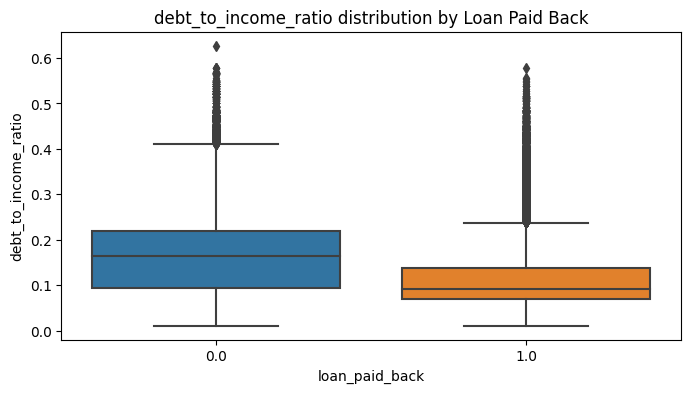

Mean of debt_to_income_ratio by loan_paid_back:
loan_paid_back
0.0    0.166564
1.0    0.109144
Name: debt_to_income_ratio, dtype: float64



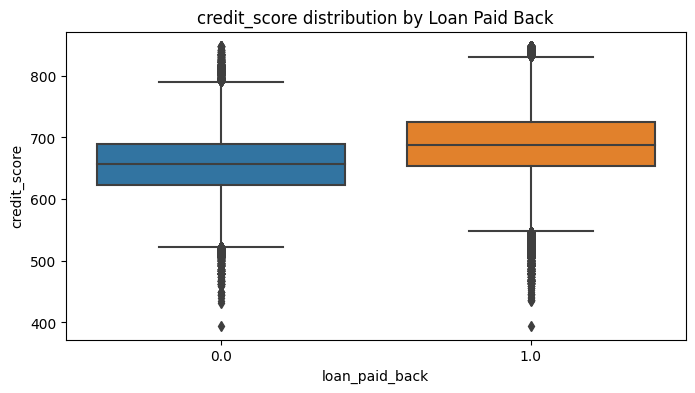

Mean of credit_score by loan_paid_back:
loan_paid_back
0.0    655.010628
1.0    687.440208
Name: credit_score, dtype: float64



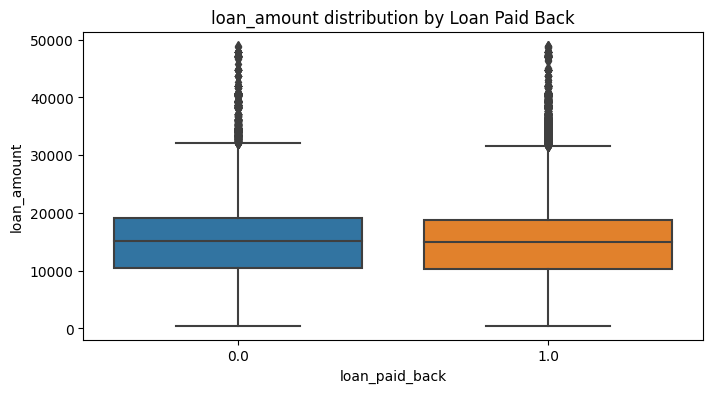

Mean of loan_amount by loan_paid_back:
loan_paid_back
0.0    15072.223883
1.0    15007.220145
Name: loan_amount, dtype: float64



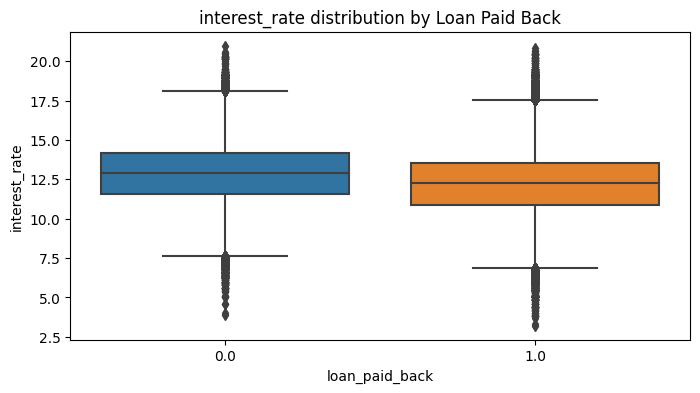

Mean of interest_rate by loan_paid_back:
loan_paid_back
0.0    12.881495
1.0    12.224088
Name: interest_rate, dtype: float64



In [11]:
# Numerical features vs target
num_cols = numerical_cols  # from previous step

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='loan_paid_back', y=col, data=train)
    plt.title(f'{col} distribution by Loan Paid Back')
    plt.show()
    
    mean_vals = train.groupby('loan_paid_back')[col].mean()
    print(f'Mean of {col} by loan_paid_back:\n{mean_vals}\n')

<Figure size 1200x500 with 0 Axes>

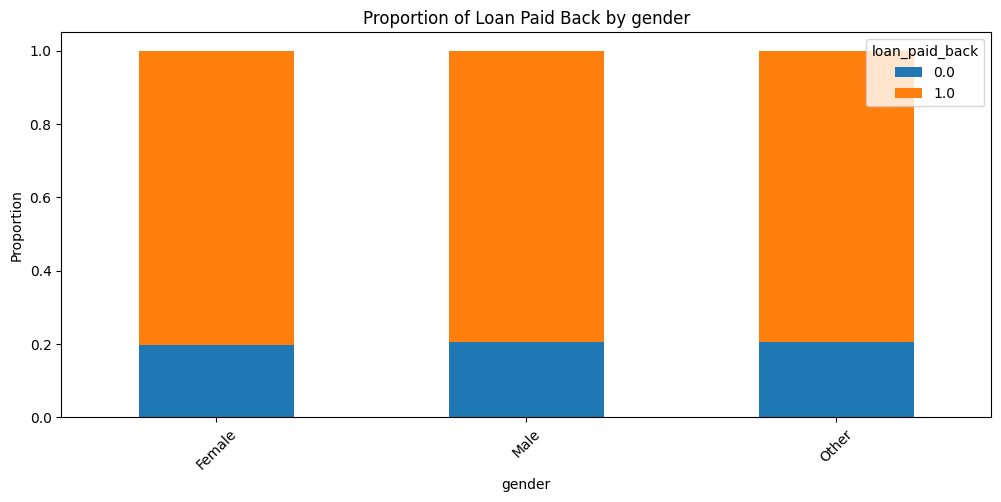

Chi-square test for gender: p-value = 7.495e-08



<Figure size 1200x500 with 0 Axes>

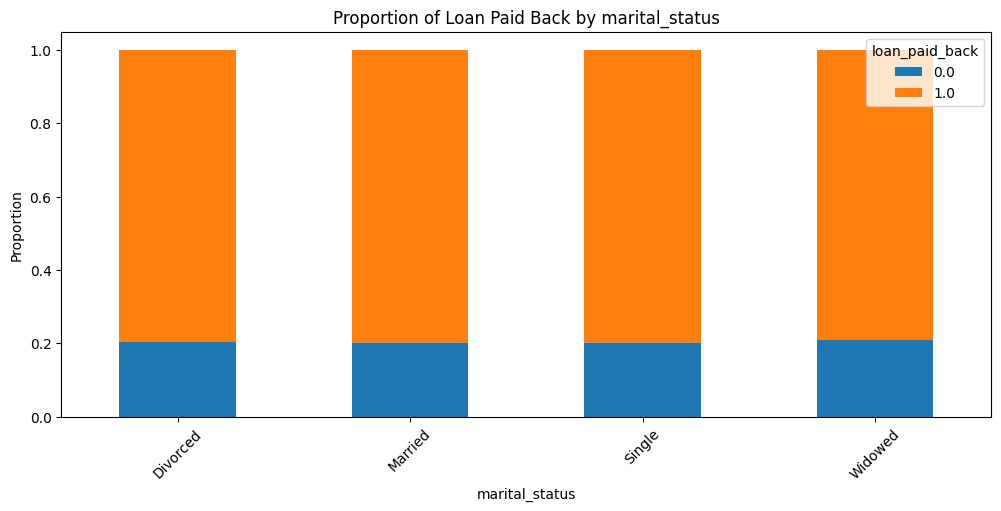

Chi-square test for marital_status: p-value = 0.2486



<Figure size 1200x500 with 0 Axes>

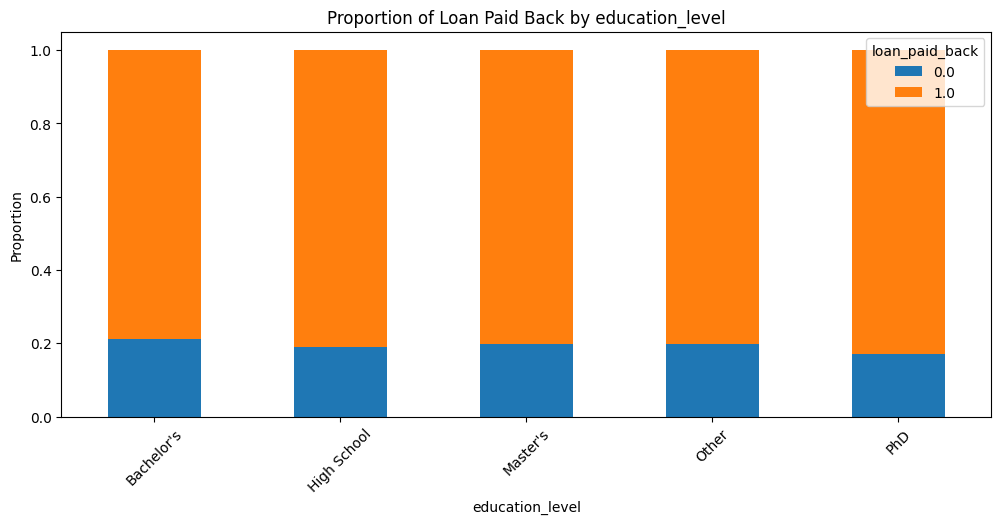

Chi-square test for education_level: p-value = 1.055e-81



<Figure size 1200x500 with 0 Axes>

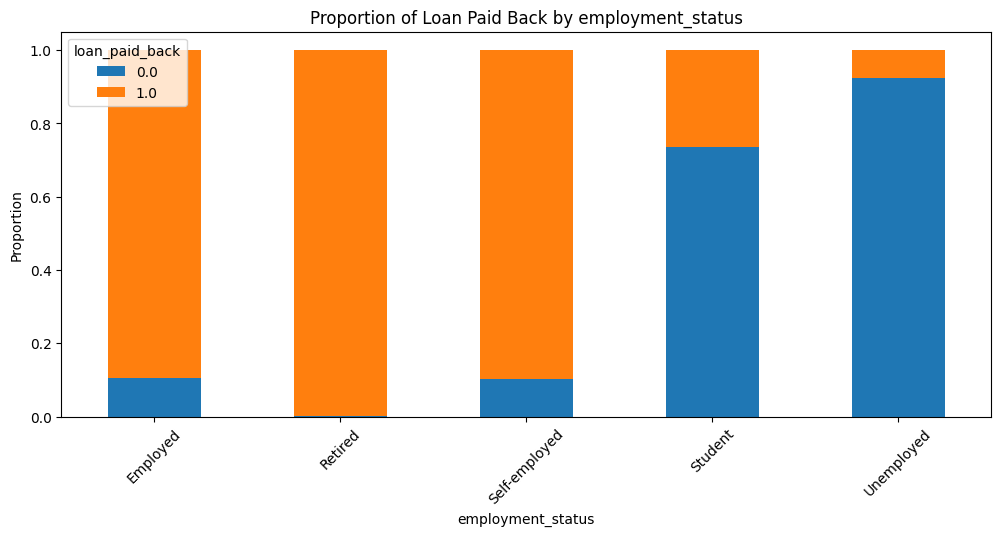

Chi-square test for employment_status: p-value = 0



<Figure size 1200x500 with 0 Axes>

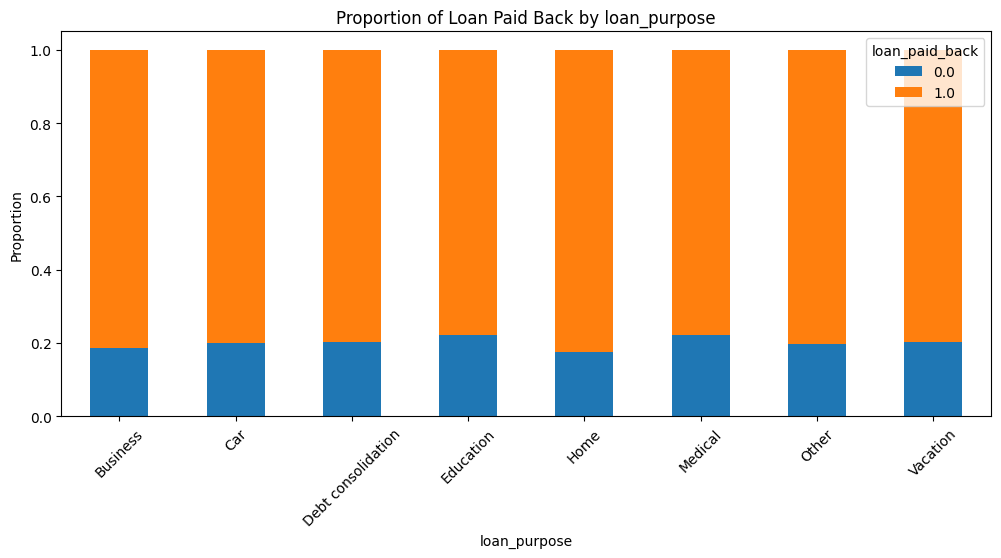

Chi-square test for loan_purpose: p-value = 1.726e-80



<Figure size 1200x500 with 0 Axes>

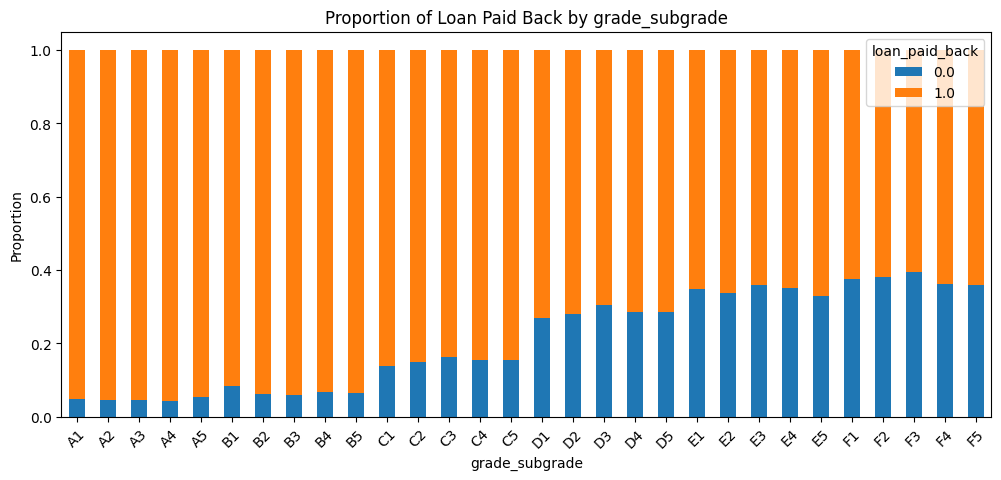

Chi-square test for grade_subgrade: p-value = 0



In [12]:
# Categorical features vs target
cat_cols = categorical_cols  # from previous step

for col in cat_cols:
    plt.figure(figsize=(12,5))
    ct = pd.crosstab(train[col], train['loan_paid_back'], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(12,5))
    plt.title(f'Proportion of Loan Paid Back by {col}')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    plt.show()

    # Chi-square test for independence
    contingency = pd.crosstab(train[col], train['loan_paid_back'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f'Chi-square test for {col}: p-value = {p:.4g}\n')

## Multivariate Analysis

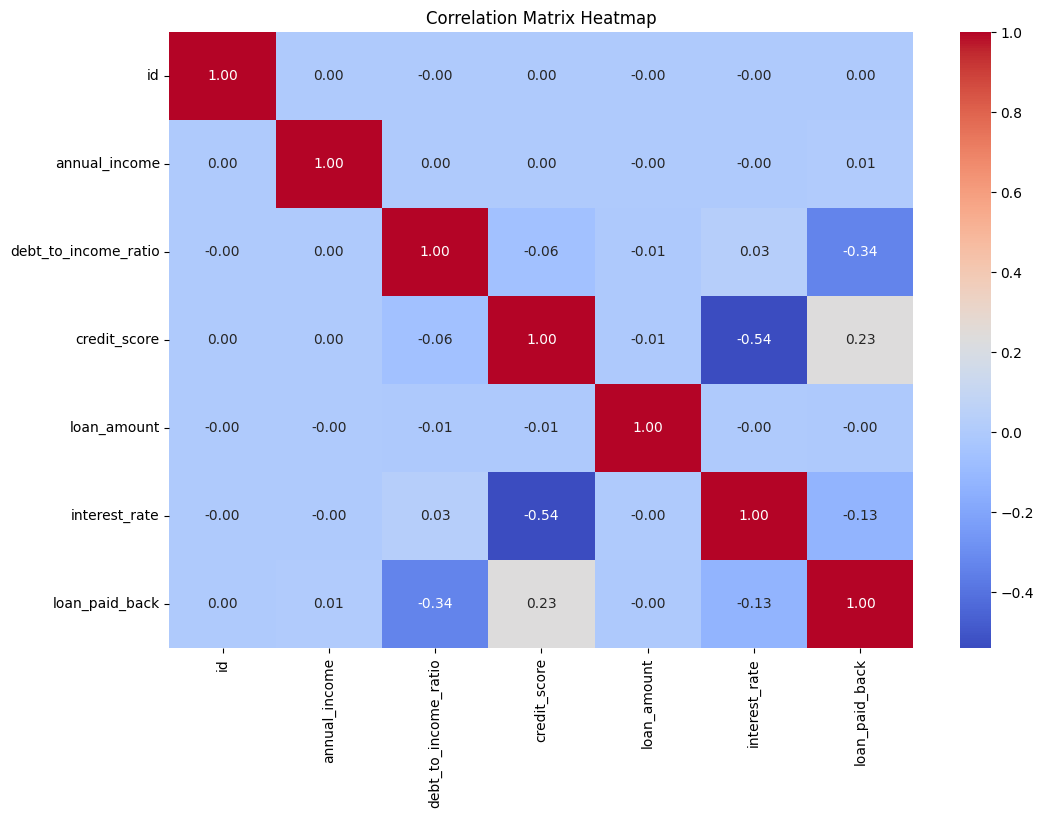

In [13]:
#  Correlation matrix heatmap
plt.figure(figsize=(12,8))
corr = train[numerical_cols.to_list() + ['loan_paid_back']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

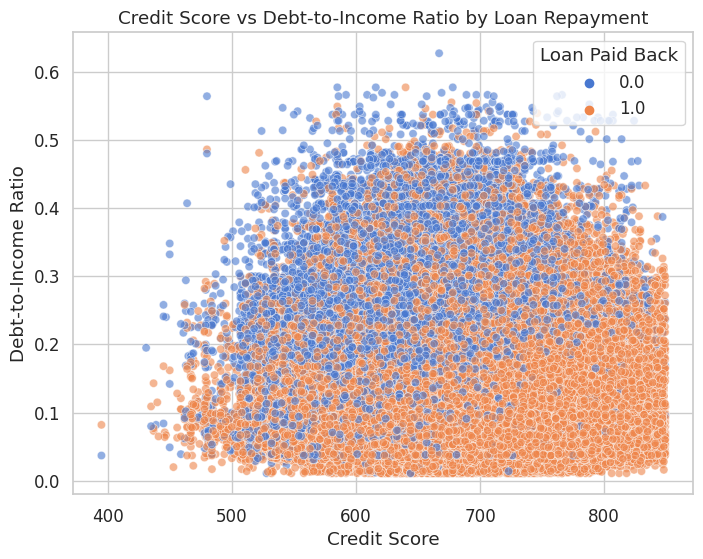

In [14]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# ----------------------------------------------------

# Credit Score vs DTI (Debt-to-Income) vs Loan Repaid
# ----------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train, 
    x='credit_score', 
    y='debt_to_income_ratio', 
    hue='loan_paid_back', 
    alpha=0.6
)
plt.title("Credit Score vs Debt-to-Income Ratio by Loan Repayment")
plt.xlabel("Credit Score")
plt.ylabel("Debt-to-Income Ratio")
plt.legend(title="Loan Paid Back", loc="upper right")
plt.show()

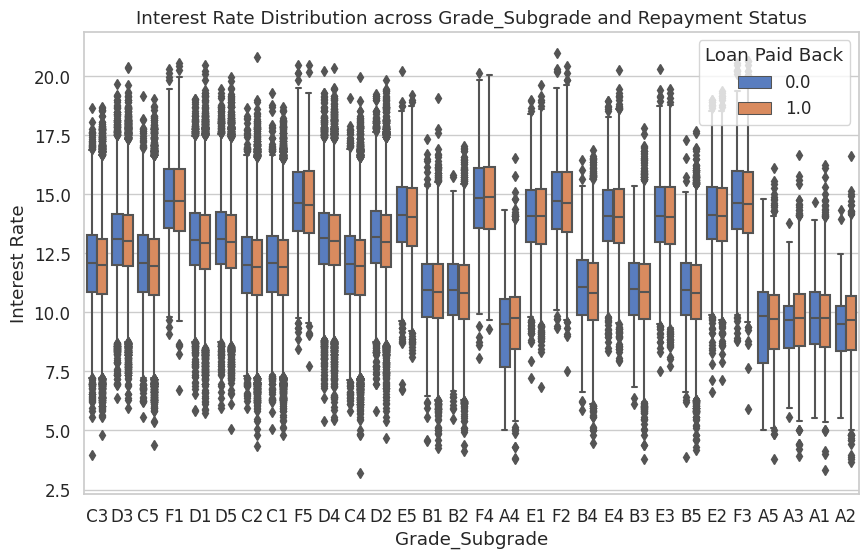

In [15]:
# ----------------------------------------------------

# Interest Rate across Grade_Subgrade categories
# ----------------------------------------------------
plt.figure(figsize=(10,6))
sns.boxplot(
    data=train,
    x='grade_subgrade',
    y='interest_rate',
    hue='loan_paid_back'
)
plt.title("Interest Rate Distribution across Grade_Subgrade and Repayment Status")
plt.xlabel("Grade_Subgrade")
plt.ylabel("Interest Rate")
plt.legend(title="Loan Paid Back")
plt.show()


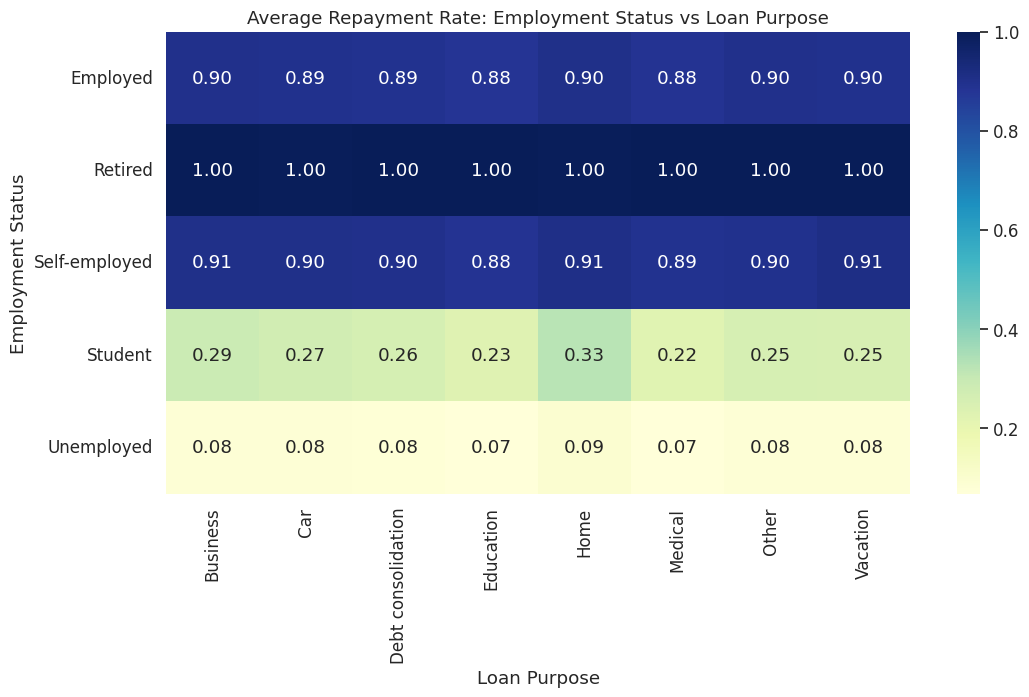

In [16]:
# ----------------------------------------------------

#  Employment Status vs Loan Purpose
# ----------------------------------------------------
cross_tab = pd.crosstab(train['employment_status'], train['loan_purpose'], 
                        values=train['loan_paid_back'], aggfunc='mean').fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Repayment Rate: Employment Status vs Loan Purpose")
plt.xlabel("Loan Purpose")
plt.ylabel("Employment Status")
plt.show()

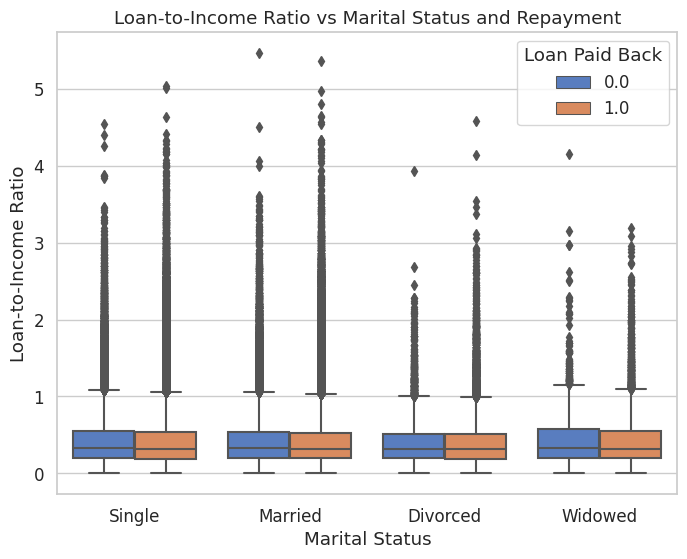

In [17]:
# ----------------------------------------------------
# Loan Amount to Income Ratio and Repayment
# ----------------------------------------------------
train['loan_to_income_ratio'] = train['loan_amount'] / (train['annual_income'] + 1)

plt.figure(figsize=(8,6))
sns.boxplot(
    data=train, 
    x='marital_status', 
    y='loan_to_income_ratio', 
    hue='loan_paid_back'
)
plt.title("Loan-to-Income Ratio vs Marital Status and Repayment")
plt.xlabel("Marital Status")
plt.ylabel("Loan-to-Income Ratio")
plt.legend(title="Loan Paid Back")
plt.show()

#  FEATURE PREPROCESSING 

In [18]:
target = 'loan_paid_back'
id_col = 'id'

num_features = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
cat_features = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


train = train.drop(columns=[id_col], errors='ignore')


X = train.drop(columns=[target])
y = train[target]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (475195, 12), Test shape: (118799, 12)


In [19]:
# Label encode 'grade_subgrade
label_enc = LabelEncoder()
X_train['grade_subgrade'] = label_enc.fit_transform(X_train['grade_subgrade'])
X_test['grade_subgrade'] = label_enc.transform(X_test['grade_subgrade'])

# One-Hot Encode other categorical features
cat_to_encode = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_to_encode)
], remainder='passthrough')

# BASELINE MODELING

# Logistic Regression

In [20]:
logreg_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

logreg_pipeline.fit(X_train, y_train)
y_pred_log = logreg_pipeline.predict(X_test)
y_proba_log = logreg_pipeline.predict_proba(X_test)[:, 1]

# ----------------------------------------------------
# Evaluate Logistic Regression
# ----------------------------------------------------
print("🔹 Logistic Regression Results")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_log))

🔹 Logistic Regression Results
              precision    recall  f1-score   support

         0.0       0.62      0.77      0.69     23900
         1.0       0.94      0.88      0.91     94899

    accuracy                           0.86    118799
   macro avg       0.78      0.83      0.80    118799
weighted avg       0.87      0.86      0.87    118799

ROC-AUC: 0.9101181493947695


# RandomForest Classifier

In [21]:
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        max_depth=12,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("\n🔹 Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))



🔹 Random Forest Results
              precision    recall  f1-score   support

         0.0       0.64      0.77      0.70     23900
         1.0       0.94      0.89      0.91     94899

    accuracy                           0.87    118799
   macro avg       0.79      0.83      0.81    118799
weighted avg       0.88      0.87      0.87    118799

ROC-AUC: 0.9134449847384543


# XGBClassifier

In [22]:
from xgboost import XGBClassifier
xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    ))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]


# Evaluate XGBoost

print("\n🔹 XGBoost Results")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))


🔹 XGBoost Results
              precision    recall  f1-score   support

         0.0       0.88      0.61      0.72     23900
         1.0       0.91      0.98      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.89      0.79      0.83    118799
weighted avg       0.90      0.90      0.90    118799

ROC-AUC: 0.9195396762054138


In [23]:
def get_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_proba)
    }

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    "Precision": [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    "Recall": [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_proba_log),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_xgb)
    ]
})
results = results.round(4)
display(results)


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.8600,0.9382,0.8829,0.9097,0.9101
1,Random Forest,0.8654,0.9395,0.8887,0.9134,0.9134
2,XGBoost,0.9044,0.9088,0.9785,0.9424,0.9195


# RandomizedSearchCV for XGBoost

In [24]:
xgb_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        eval_metric='auc',
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])  # handle imbalance
    ))
])


param_grid = {
    'model__n_estimators': [200, 300, 400, 500],
    'model__max_depth': [5, 7, 9],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2],
    'model__min_child_weight': [1, 3, 5]
}


print("🔍 Running RandomizedSearchCV for XGBoost... (this may take a few minutes)")

xgb_random = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_grid,
    n_iter=25,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train)

print("\n✅ Best Parameters Found:")
print(xgb_random.best_params_)


best_xgb = xgb_random.best_estimator_
y_pred_best = best_xgb.predict(X_test)
y_proba_best = best_xgb.predict_proba(X_test)[:, 1]

print("\n🔹 XGBoost Tuned Model Performance\n")
print(classification_report(y_test, y_pred_best))
print("ROC-AUC Score:", round(roc_auc_score(y_test, y_proba_best), 4))


🔍 Running RandomizedSearchCV for XGBoost... (this may take a few minutes)
Fitting 3 folds for each of 25 candidates, totalling 75 fits

✅ Best Parameters Found:
{'model__subsample': 1.0, 'model__n_estimators': 400, 'model__min_child_weight': 5, 'model__max_depth': 9, 'model__learning_rate': 0.05, 'model__gamma': 0.2, 'model__colsample_bytree': 0.6}

🔹 XGBoost Tuned Model Performance

              precision    recall  f1-score   support

         0.0       0.64      0.79      0.71     23900
         1.0       0.94      0.89      0.92     94899

    accuracy                           0.87    118799
   macro avg       0.79      0.84      0.81    118799
weighted avg       0.88      0.87      0.87    118799

ROC-AUC Score: 0.9204


<Figure size 800x600 with 0 Axes>

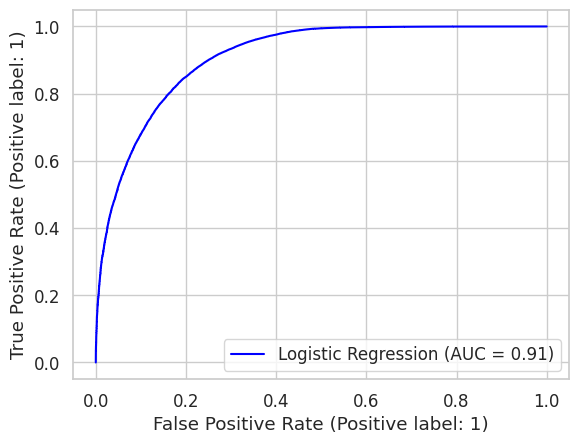

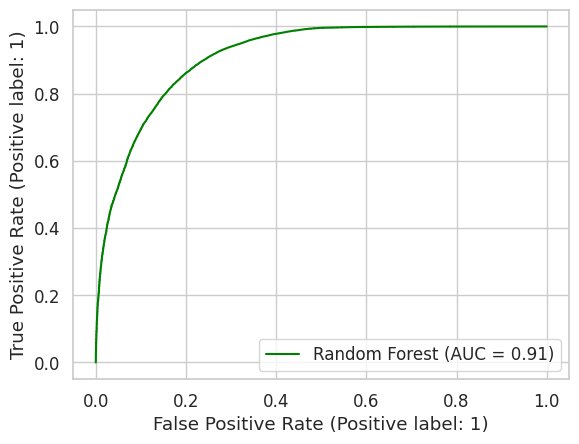

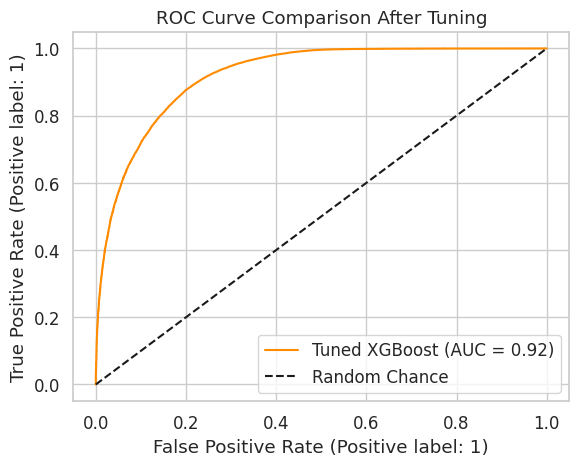

In [25]:
plt.figure(figsize=(8,6))
RocCurveDisplay.from_predictions(y_test, y_proba_log, name="Logistic Regression", color='blue')
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name="Random Forest", color='green')
RocCurveDisplay.from_predictions(y_test, y_proba_best, name="Tuned XGBoost", color='darkorange')
plt.title("ROC Curve Comparison After Tuning")
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.legend()
plt.show()

In [26]:
len(best_xgb.named_steps['model'].feature_importances_)


27


📊 Top 15 Most Important Features:
                            Feature  Importance
17     employment_status_Unemployed    0.847248
16        employment_status_Student    0.098038
14        employment_status_Retired    0.020452
1              debt_to_income_ratio    0.008801
15  employment_status_Self-employed    0.005587
25                   grade_subgrade    0.005014
2                      credit_score    0.003362
4                     interest_rate    0.000927
20           loan_purpose_Education    0.000683
13              education_level_PhD    0.000661
3                       loan_amount    0.000657
21                loan_purpose_Home    0.000623
10      education_level_High School    0.000618
22             loan_purpose_Medical    0.000618
0                     annual_income    0.000605


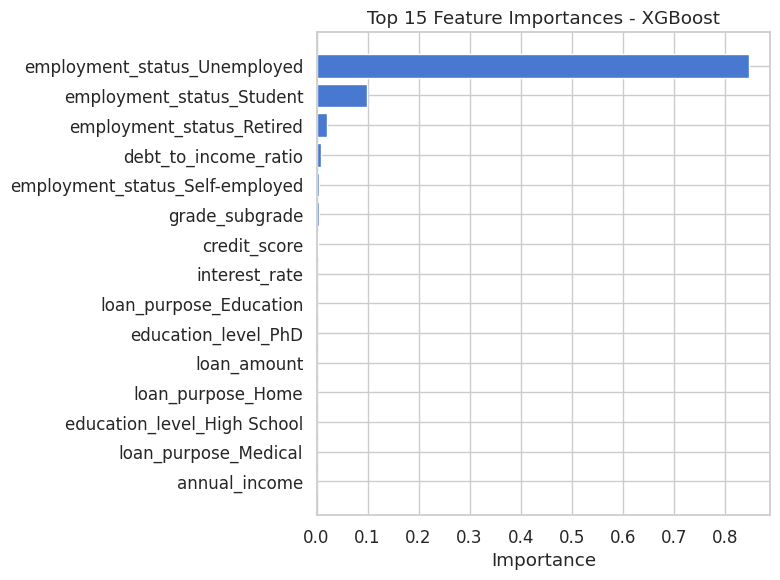

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


feature_importance = best_xgb.named_steps['model'].feature_importances_


num_features = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
cat_features = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose']


ohe = best_xgb.named_steps['preprocess'].named_transformers_['cat']


ohe_feature_names = list(ohe.get_feature_names_out(cat_features))

# Combine numeric + encoded + remainder (grade_subgrade)
all_features = num_features + ohe_feature_names + ['grade_subgrade']

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importance[:len(all_features)]
}).sort_values(by='Importance', ascending=False)

# Display Top Features
print("\n📊 Top 15 Most Important Features:")
print(importance_df.head(15))


plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'].head(15)[::-1], importance_df['Importance'].head(15)[::-1])
plt.title("Top 15 Feature Importances - XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


# Submission

In [28]:

test_copy = test.copy()


test_copy['loan_to_income_ratio'] = test_copy['loan_amount'] / (test_copy['annual_income'] + 1)


test_copy['grade_subgrade'] = label_enc.transform(test_copy['grade_subgrade'])


test_pred_proba = best_xgb.predict_proba(test_copy)[:, 1]


submission_df = pd.DataFrame({
    'id': test_copy['id'],
    'loan_paid_back': test_pred_proba
})

# 5️Save submission file
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")

Submission file created successfully!


In [29]:
import joblib
joblib.dump(best_xgb, "best_xgb_model.pkl")
print("✅ Model saved successfully as best_xgb_model.pkl")


✅ Model saved successfully as best_xgb_model.pkl
